In [87]:
from shapely.geometry import box, Point, LineString
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd

In [35]:
bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])

In [170]:
edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
list(edges.keys())

,ori_node,des_node,ori_layer,des_layer,minutes,km
0,325,31793,1,1,7,0.707
1,338,36564,1,1,7,0.920
2,348,46689,1,1,5,0.439
3,601,44530,1,1,495,164.555
4,601,44678,1,1,465,212.353
...,...,...,...,...,...,...
475497,261577,261577,5,4,1,0.000
475498,262053,262053,4,5,1,0.000
475499,262053,262053,5,4,1,0.000
475500,262062,262062,4,5,1,0.000


In [168]:
nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.lon, nodes.lat))
list(nodes.keys())

['node', 'layer', 'lat', 'lon', 'zone', 'atcocode', 'geometry']

In [169]:
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')
list(layers.keys())

['layer', 'layerLabel']

In [ ]:
fig, ax = plt.subplots(figsize=(17, 17))
nodes.plot(ax=ax, markersize=1)

In [51]:
clipped_nodes = gpd.clip(nodes, boundary)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
clipped_nodes.plot(ax=ax, markersize=1)

In [104]:
nodes2 = clipped_nodes.set_index(keys=['node', 'layer'])

In [82]:
des_edges = edges[edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
ori_edges = edges[edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]

In [85]:
new_edges = des_edges.append(ori_edges)

In [108]:
new_nodes = nodes.set_index(['node', 'layer'])
new_edges['geometry'] = new_edges.apply(lambda x: LineString([new_nodes.loc[(x.ori_node, x.ori_layer)].geometry, new_nodes.loc[(x.des_node, x.des_layer)].geometry]), axis=1)

In [161]:
clipped_new_edges = gpd.clip(new_edges.reset_index(), boundary)

<AxesSubplot:>

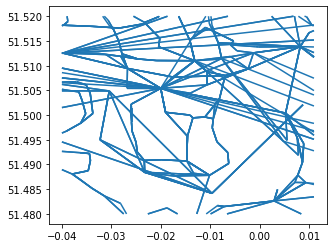

In [164]:
clipped_new_edges[~clipped_new_edges.is_empty].plot()